In [7]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({
        'font.family' : 'Times',
        'font.size' : 10,
        'axes.titlesize' : 10,
        'axes.labelsize' : 10,
        'xtick.labelsize' : 10,
        'ytick.labelsize' : 10,
        'legend.fontsize': 10,
        'lines.markersize': 2,
        'legend.shadow' : False,
        'legend.framealpha' : 1,
        'legend.fancybox' : True,
        'legend.edgecolor' : 'black',
        'legend.handlelength' : 1,
        'legend.borderpad' : 0.75,
        'patch.linewidth' : 0.75,
        'text.usetex' : True,
        'text.latex.preamble' : r'''
    \usepackage{amsmath}
    \usepackage{amssymb}
    \usepackage{times}
    \usepackage{amsfonts}
''',
    })

greens = ['#295827', '#7bbf64', '#cbf6bb']
blues = ['#291b85', '#6653e0', '#c6befa']
reds = ['#841a1a', '#e15454', '#fabdbd']

def poly_transform(x, D):
  assert x.ndim == 1, "Expected x.shape == (N,)"
  pwr = torch.arange(1, D+1)
  features = x[:,None] ** pwr
  return features

def add_bias(x):
  ones = torch.ones(x.shape[0], 1)
  return torch.hstack([ones, x])

def poly_basis(n_terms):
    return lambda x: add_bias(poly_transform(x, n_terms))

def even_poly_basis(n_terms):
    return lambda x: add_bias(poly_transform(x, 2*n_terms)[:, 1::2])

def odd_poly_basis(n_terms):
    return lambda x: add_bias(poly_transform(x, 2*n_terms)[:, 0::2])

It is numerically instable to calculate
$$y = w_0 x^0 + w_1 x^1 + w_2 x^2 + \ldots w_d x^d$$
due to exponentiation of $x$. Notice the percentage of terms preserved drops as $d$ grows:


100%|██████████| 100/100 [00:00<00:00, 5655.14it/s]


[]

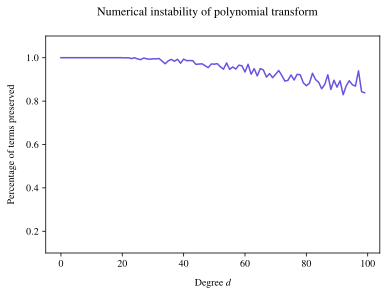

In [8]:
stable_rates = []
for d in tqdm(torch.arange(0, 100)):
  x = torch.distributions.Uniform(-1.0, 1.0).sample((100,))
  phi = poly_basis(d)(x)
  stable_rates.append(phi.count_nonzero() / phi.numel())

fig, ax = plt.subplots(1, 1)

fig.suptitle('Numerical instability of polynomial transform')
ax.plot(stable_rates, c=blues[1])
ax.set_ylim(0.1, 1.1)
ax.set_xlabel('Degree $d$', labelpad=10)
ax.set_ylabel('Percentage of terms preserved', labelpad=10)
plt.plot()

We can try rewriting $y$ as $$y = w_0 x \left(1 + \frac{w_1}{w_0}x\left(1 + \frac{w_2}{w_1}x\left(1 + \ldots\right)\right)\right)$$ and check whether this is accurate.

In [9]:
def instable_poly(x, w):
  d = len(w)
  phi = poly_basis(d-1)(x)
  stable_rate = phi.count_nonzero() / phi.numel()
  y = phi @ w
  return y, stable_rate

def stable_poly(x, w):
  '''
  Instead of returning `phi(x)`, we return `w @ phi(x)`.
  '''
  stable_el = 0
  total_el = 0
  n, d = len(x), len(w)
  z = torch.ones(n)
  for i in range(1, d)[::-1]:
    rhs = w[i]/w[i-1] * x * z
    stable_el += rhs.count_nonzero()
    total_el += rhs.numel()
    z = 1 + rhs
  y = w[0] * z
  return y, stable_el / total_el if total_el > 0 else 1



100%|██████████| 99/99 [00:00<00:00, 760.63it/s]


[]

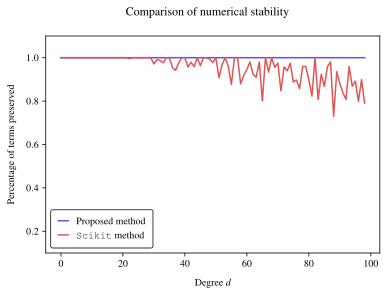

In [11]:
n = 10
d = 100
stable_rates_old = []
stable_rates_new = []
alike = []
for d in tqdm(torch.arange(1, 100)):
  x = torch.distributions.Uniform(-1.0, 1.0).sample((n,))
  w = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1])).sample((d,)).reshape(-1)

  phi_stable, new_rt = stable_poly(x, w)
  phi_instable, old_rt = instable_poly(x, w)

  stable_rates_old.append(old_rt)
  stable_rates_new.append(new_rt)
  alike.append(phi_stable.equal(phi_instable))

fig, ax = plt.subplots(1, 1)

fig.suptitle('Comparison of numerical stability')
ax.plot(stable_rates_new, c=blues[1], label='Proposed method')
ax.plot(stable_rates_old, c=reds[1], label=r'$\verb|Scikit|$ method')
ax.set_ylim(0.1, 1.1)
ax.set_xlabel('Degree $d$', labelpad=10)
ax.set_ylabel('Percentage of terms preserved', labelpad=10)
ax.legend()
plt.plot()